In [1]:
import matplotlib
import numpy as np
import PIL
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import coremltools
from pycoreimage.pyci import cimg, show, color, inset

In [169]:
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = [30,30]
from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 90% : important; }</style>"))
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [170]:
# print(cimg.inputs('CIOverlayBlendMode'))
for i,f in enumerate(cimg.filters()):
    print('{:3d}\t {}'.format(i,f))

  0	 CIAccordionFoldTransition
  1	 CIAdditionCompositing
  2	 CIAffineClamp
  3	 CIAffineTile
  4	 CIAffineTransform
  5	 CIAreaAverage
  6	 CIAreaHistogram
  7	 CIAreaMaximum
  8	 CIAreaMaximumAlpha
  9	 CIAreaMinimum
 10	 CIAreaMinimumAlpha
 11	 CIAreaMinMax
 12	 CIAreaMinMaxRed
 13	 CIAttributedTextImageGenerator
 14	 CIAztecCodeGenerator
 15	 CIBarcodeGenerator
 16	 CIBarsSwipeTransition
 17	 CIBicubicScaleTransform
 18	 CIBlendWithAlphaMask
 19	 CIBlendWithBlueMask
 20	 CIBlendWithMask
 21	 CIBlendWithRedMask
 22	 CIBloom
 23	 CIBokehBlur
 24	 CIBoxBlur
 25	 CIBumpDistortion
 26	 CIBumpDistortionLinear
 27	 CICameraCalibrationLensCorrection
 28	 CICheckerboardGenerator
 29	 CICircleSplashDistortion
 30	 CICircularScreen
 31	 CICircularWrap
 32	 CIClamp
 33	 CICMYKHalftone
 34	 CICode128BarcodeGenerator
 35	 CIColorBlendMode
 36	 CIColorBurnBlendMode
 37	 CIColorClamp
 38	 CIColorControls
 39	 CIColorCrossPolynomial
 40	 CIColorCube
 41	 CIColorCubesMixedWithMask
 42	 CIColorCubeW

In [174]:
model = coremltools.models.MLModel('models/DeepLab.mlmodel')
labels = ['Background','Plane','Bicycle','Bird','Boat','Bottle','Bus','Car','Cat','Chair','Cow','Diningtable','Dog','Horse','Motorbike','Person','Pottedplant','Sheep','Sofa','Train','Tvmonitor']
dictionary = {'Background':0,'Plane':1,'Bicycle':2,'Bird':3,'Boat':4,'Bottle':5,'Bus':6,'Car':7,'Cat':8,'Chair':9,'Cow':10,'Diningtable':11,'Dog':12,'Horse':13,'Motorbike':14,'Person':15,'Pottedplant':16,'Sheep':17,'Sofa':18,'Train':19,'Tvmonitor':20}
spec = model._spec
input_width = spec.description.input[0].type.imageType.width
input_height = spec.description.input[0].type.imageType.height

# TODO: import random image from unsplash
img = PIL.Image.open('samples/person_woman_2.jpg')
image_width = np.array(img).shape[1]
image_height = np.array(img).shape[0]
resized_img = img.resize((input_width, input_height), PIL.Image.BILINEAR)
y = model.predict({"image": resized_img}, usesCPUOnly=False)
mask = y['scores']

scale_width = image_width/input_width
scale_height = image_height/input_height
ci_mask_resized = cimg(np.array(mask)).scale(scale_width,scale_height)
ci_fg = cimg(np.array(img, float) / 255)
ci_bg = cimg(np.array(img, float) / 255)

src = """ kernel vec4 color(__sample img, __sample mask, float index) {
    vec4 pixValue;
    pixValue.r = pixValue.g = pixValue.b = pixValue.a = 0;
    if (mask.r >= index - 0.0039 && mask.r <= index + 0.0039){
        pixValue.r = pixValue.g = pixValue.b = pixValue.a = 1;
    }
    return pixValue;
}"""

bilateral_filter = """ kernel vec4 bilateral(sampler u, sampler fg, float k, float colorInv, float spatialInv)
{
  vec2 dc = destCoord();
  vec2 pu = samplerCoord(u);
  vec2 uDelta = samplerTransform(u, dc+vec2(1.0)) - pu;
  vec4 u_0 = sample(u, pu);

  vec2 pfg = samplerCoord(fg);
  vec2 fgDelta = samplerTransform(fg, dc+vec2(1.0)) - pfg;
  vec4 fg_0 = sample(fg, pfg);

  vec4 C = vec4(0.0);
  float W = 0.0;
  for (float x = -k; x <= k; x++) {
    for (float y = -k; y <= k; y++){
      float ws = exp(-(x*x+y*y) * spatialInv);
      vec4 u_xy  = sample(u, pu + vec2(x,y)*uDelta);
      vec4 fg_xy  = sample(fg, pfg + vec2(x,y)*fgDelta);
      vec3 diff = fg_xy.rgb-fg_0.rgb;
      float wc = exp(-dot(diff,diff) * colorInv);
      W += ws * wc;
      C += ws * wc * u_xy;
    }
  }
  return W < 0.0001 ? u_0 : C / W;  
}
"""

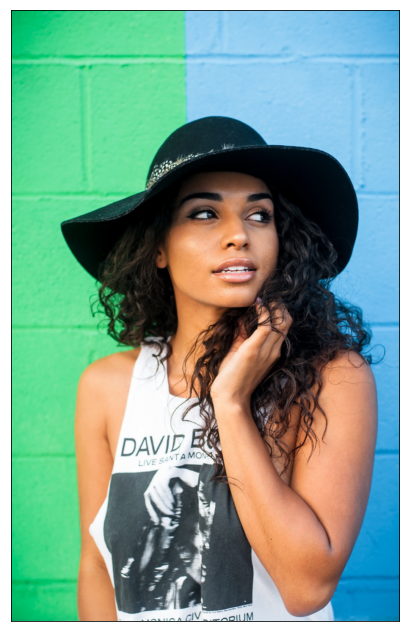

In [175]:
indexValue = dictionary['Person']*12/255.0
ci_mask_blured = ci_mask_resized.applyKernel(bilateral_filter, ci_fg, 10, 2000,0.001)
show([ci_fg])

## New Highlight

In [186]:
def highlight(img, mask, contrast, saturation):
    ci_fg = img.colorControls(contrast=1.2, saturation = 1.2)
    ci_bg = img.colorControls(contrast=contrast, saturation = saturation)
    output = ci_fg.blendWithMask(backgroundImage=ci_bg, maskImage=ci_mask_blured)
    return output
    
def show_highlight(image, mask, contrast, saturation):
    output = highlight(image, mask, contrast, saturation)
    show(output)
    
interact(show_highlight, image = fixed(ci_bg), 
         mask = fixed(ci_mask_blured), 
         contrast=widgets.FloatSlider(min=0,max=2,step=0.05,value=0.7),
        saturation=widgets.FloatSlider(min=0,max=2,step=0.05,value=0.7));

interactive(children=(FloatSlider(value=0.7, description='contrast', max=2.0, step=0.05), FloatSlider(value=0.…

## Color Highlight

In [181]:
# print(cimg.inputs('gaussianBlur'))
def color(img, mask, contrast, saturation):
    ci_fg = img.colorControls(contrast=1.2, saturation = 1.2)
    ci_bg = img.colorControls(contrast=contrast, saturation = saturation)
    output = ci_fg.blendWithMask(backgroundImage=ci_bg, maskImage=ci_mask_blured)
    return output
    
def show_color(image, mask, contrast, saturation):
    output = color(image, mask, contrast, saturation)
    show(output)
    
interact(show_color, image = fixed(ci_bg), 
         mask = fixed(ci_mask_blured), 
         contrast=widgets.FloatSlider(min=0,max=2,step=0.05,value=0.7),
        saturation=widgets.FloatSlider(min=0,max=2,step=0.05,value=0.7));

interactive(children=(FloatSlider(value=0.7, description='contrast', max=2.0, step=0.05), FloatSlider(value=0.…

## Bokeh Blur Hilight

In [195]:
premultiply = """ kernel vec4 color(__sample img, __sample mask) {
    vec4 pixValue = img;
    pixValue = img * (1.0-mask.r);
    return pixValue;
}"""


demultiply = """ kernel vec4 color(__sample img) {
    vec4 pixValue = img;
    if (img.a > 0.0){
        pixValue = img / (img.a);
    }
    return pixValue;
}"""


def bokeh(img, mask, radius):
    ci_fg = img
    ci_bg = img.applyKernel(premultiply,mask)
    ci_bg = ci_bg.bokehBlur(radius=30)
    ci_bg = ci_bg.applyKernel(demultiply)
#     ci_bg = img.bokehBlur(radius=30)

    output = ci_fg.blendWithMask(backgroundImage=ci_bg, maskImage=mask)
    return output
    
def show_bokeh(image, mask, radius):
    output = bokeh(image, mask, radius)
    show(output)
    
interact(show_bokeh, image = fixed(ci_bg), 
         mask = fixed(ci_mask_blured),
         radius=widgets.IntSlider(min=1,max=30,step=1,value=10));

interactive(children=(IntSlider(value=10, description='radius', max=30, min=1), Output()), _dom_classes=('widg…

(770, 513, 4)


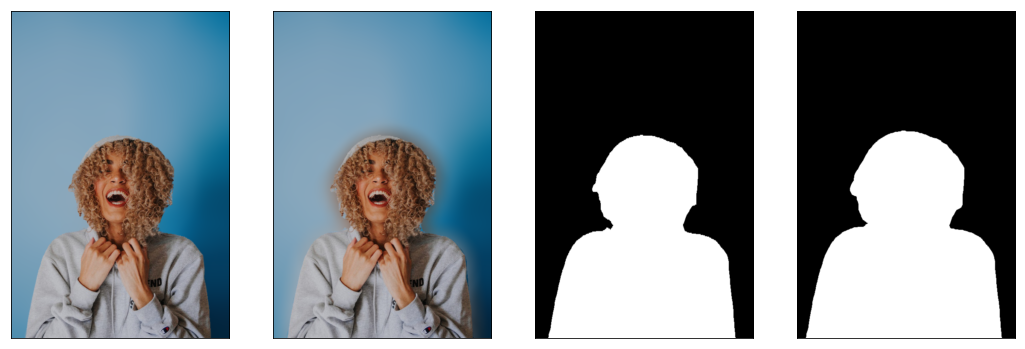

In [167]:

# print(cimg.inputs('gaussianBlur'))
premultiply = """ kernel vec4 color(__sample img, __sample mask) {
    vec4 pixValue = img;
    pixValue = img * (1.0-mask.r);
    return pixValue;
}"""


demultiply = """ kernel vec4 color(__sample img) {
    vec4 pixValue = img;
    if (img.a > 0.0){
        pixValue = img / (img.a);
    }
    return pixValue;
}"""



identity = """ kernel vec4 color(__sample img) {
    vec4 pixValue = img;
   
    return pixValue;
}"""

mask_clean = """ kernel vec4 color(__sample mask, float index) {
    vec4 pixValue;
    pixValue.r = pixValue.g = pixValue.b = pixValue.a = 0;
    if (mask.r >= index - 0.0039 && mask.r <= index + 0.0039){
        pixValue.r = pixValue.g = pixValue.b = pixValue.a = 1;
    }
    return pixValue;
}"""

demultiply = """ kernel vec4 color(__sample img) {
    vec4 pixValue = img;
    if (img.a > 0.0){
        pixValue = img / (img.a);
    }
    return pixValue;
}"""

dictionary = {'Background':0,'Plane':1,'Bicycle':2,'Bird':3,'Boat':4,'Bottle':5,'Bus':6,'Car':7,'Cat':8,'Chair':9,'Cow':10,'Diningtable':11,'Dog':12,'Horse':13,'Motorbike':14,'Person':15,'Pottedplant':16,'Sheep':17,'Sofa':18,'Train':19,'Tvmonitor':20}
img = PIL.Image.open('samples/person_woman.jpg').convert('RGBA')
image_width = np.array(img).shape[1]
image_height = np.array(img).shape[0]
resized_img = img.resize((input_width, input_height), PIL.Image.BILINEAR)
ci_bg = cimg(np.array(img, float) / 255) #.applyKernel(identity)
ci_fg = cimg(np.array(img, float) / 255) #.applyKernel(identity)

y = model.predict({"image": resized_img}, usesCPUOnly=False)
mask = y['scores']
scale_width = image_width/input_width
scale_height = image_height/input_height
ci_mask_resized = cimg(np.array(mask)).scale(scale_width,scale_height)

indexValue = dictionary['Person']*12/255.0

cleaned_mask = ci_mask_resized.applyKernel(mask_clean,indexValue)
cleaned_mask_1 = cleaned_mask.morphologyMaximum(radius=10)
cleaned_mask_2 = cleaned_mask.morphologyMaximum(radius=10)

background = ci_bg.applyKernel(premultiply, cleaned_mask_1)
output = background.bokehBlur(radius=40)
output = output.applyKernel(demultiply)

output = ci_fg.blendWithMask(backgroundImage=output, maskImage=cleaned_mask)
# output = ci_fg.blendWithMask(backgroundImage=output, maskImage=cleaned_mask).sourceAtopCompositing(backgroundImage=ci_bg)

back = ci_bg.bokehBlur(radius=40)
output_original = ci_fg.blendWithMask(backgroundImage=back, maskImage=cleaned_mask)


# print(dir(result))
print(ci_bg.render().shape)
# 
# show([output,output_original])
show([output,output_original,cleaned_mask,cleaned_mask_1])